In [104]:
# Add path with autoencoding code
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../code_autoencoding')

import numpy as np
from numpy import dot
from numpy.linalg import norm

import pandas as pd

import glob
import itertools
from itertools import combinations

import data_loader as dl
import autoencoder
import trainer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [51]:
# Helper functions for getting cosine similarity from drug response vectors.

# Function: compute and return the cosine similarity between two arrays
def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

# Function: computes and returns the cosine simiarities between all combinations of the vectors in the passed array. 
# Set flag mean = True to return the mean cosine simarity rather than an array of all similarities 
def combs_cos_sim(arr, mean = True):

    if len(arr) < 2:
        #print(len(arr))
        return 1
    combs = list(combinations(np.arange(len(arr)), 2))
    sims = [cos_sim(arr[c[0]], arr[c[1]]) for c in combs]
    
    if mean: 
        return np.mean(sims)
    else:
        return sims

#### Read in both the data and meta data for LINCS level 2

In [89]:
data_path = "../data/shared_landmark_counts_vecs.gctx_n1269922x960.gctx"
lincs_data = dl.load_CMap(data_path)
lincs_data = lincs_data.iloc[:,0:50000]
#lincs_data = lincs_data.iloc[:, np.random.choice(np.arange(lincs_data.shape[1]), size=500000, replace=False)]
lincs_vectors = dict(dl.vectorize(lincs_data))



In [90]:
meta_data_path  = "../meta_data/GSE92742_Broad_LINCS_inst_info.txt"
meta_data = pd.read_csv(meta_data_path, sep = '\t')

meta_data['pert_time'] = meta_data['pert_time'].apply(str)
meta_data['pert_dose'] = meta_data['pert_dose'].apply(str)
meta_data['appPert_id'] = meta_data[['pert_iname', 'pert_dose', 'pert_time']].agg('_'.join, axis=1)

<ipython-input-90-aa6d47874146>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_data = pd.read_csv(meta_data_path, sep = '\t')


#### Remove meta data for which there is no reponse in the LINCS data 

In [91]:
meta_data = meta_data[meta_data['inst_id'].isin(lincs_data.columns)]

#### Get the vector IDs (inst_id's) corresponding to each pertubation-cell combination

In [92]:
def get_pert_cell_combs(meta_df, pert_ident = 'pert_iname', cell_list = False):
    
    # Strip the meta data to include only the cell types of interest, if desired. 
    if (cell_list != False):
        meta_df = meta_df[meta_df['cell_id'].isin(cell_list)]
    
    # Get a list of perturbation, cell, and instance combinations 
    pert_cell_combs = list((zip(meta_df[pert_ident], meta_df.cell_id, meta_df.inst_id)))
    
    # Construct a dict that maps a perturbation and cell combination to a list of associated vector IDs
    vec_ids = dict()
    
    for i in range(len(pert_cell_combs)):
        pert, cell, inst = pert_cell_combs[i]
        
        if (pert,cell) in vec_ids:
            vec_ids[(pert, cell)].append(inst)
        else:
            vec_ids[(pert,cell)] = [inst]
    
    return vec_ids

cells = ['MCF7','A375','HT29','PC3','HA1E','YAPC','HELA']
pert_cell_vector_dict = get_pert_cell_combs(meta_data, pert_ident = 'pert_iname', cell_list = False)

#### Compute the mean vector for each pertubation-cell combination. This is the average response for a given cell type and drug in the native space.  Store the mean response to DMSO separately.

In [93]:
def get_mean_vec_from_control(all_vectors, vec_group_dict, cnt_condition = "DMSO", batch_cor = True):
    
    group_mean_vectors = dict()
    cnt_mean_vectors = dict()

    for k, v in vec_group_dict.items():
        
        # Get all the vectors within the cell-pert group
        group_vectors = {inst_id:(all_vectors[inst_id]) for inst_id in v}

        # If we're looking at the control condition for a cell, keep the mean separate. 
        # Use PCA + k-means clustering to eliminate samples from the smaller batch
        if(cnt_condition in k[0]):
            
            # Often the control response will contain more than one cluster due to batch effects. Using only the largest cluster
            # for normalization cleans things up. 
            if batch_cor and len(group_vectors) > 1:
                # PCA
                pca = PCA(n_components=2)

                pc_df = pd.DataFrame(data = pca.fit_transform(list(group_vectors.values())), columns = ['PC1', 'PC2'])

                # Clustering
                kmeans = KMeans(n_clusters=2)
                kmeans.fit(pc_df)
                pc_df['clusters'] = list(kmeans.labels_)
                pc_df['keys'] = group_vectors.keys()

                # Visualize for sanity
                #plt.scatter(pc_df.PC1, pc_df.PC2, c = pc_df.clusters)
                #plt.show()

                # Drop samples from the smaller cluster
                largest_cluster = max(set(pc_df.clusters), key = list(pc_df.clusters).count)
                cnt_keep = pc_df[pc_df.clusters == largest_cluster]['keys']              

                cnt_mean_vectors[k[1]] = np.mean([group_vectors[keep] for keep in cnt_keep], axis = 0)
                    
            else:
                cnt_mean_vectors[k[1]] = np.mean(list(group_vectors.values()), axis = 0)
                
        else:
            # Compute the mean vector for each group
            group_mean_vectors[k] = np.mean(list(group_vectors.values()), axis = 0)
                
    
    # Stubtract the mean control vector from everything for each group. Drop cnt vectors and those without a control
    cnt_normed_mean_vectors = group_mean_vectors.copy()
    
    for k, v in group_mean_vectors.items():
        
        if k[1] == cnt_condition:
            cnt_normed_mean_vectors.pop(k)
        elif k[1] in cnt_mean_vectors:
            cnt_normed_mean_vectors[k] = v - cnt_mean_vectors[k[1]]
        else:
            cnt_normed_mean_vectors.pop(k)
    
    return cnt_normed_mean_vectors

In [94]:
mean_vectors_native = get_mean_vec_from_control(lincs_vectors, pert_cell_vector_dict, cnt_condition = "DMSO", batch_cor = True)

#### For each perturbation, get the cosine similarity between the mean responses for each cell

In [95]:
def get_group_cos_sims(all_vectors, meta_df, grp_id = 'pert_iname', ind_id = 'cell_id', mean = True):
    
    # Remove any meta data entries tha don't have corresponding vectors
    grps, inds = (zip(*mean_vectors_native.keys()))
    meta_df =  meta_df.loc[(meta_df[grp_id].isin(grps)) & (meta_df[ind_id].isin(inds))]
    
    grp_cos_sims = dict()

    for grp in set(meta_df[grp_id]):

        keys = [(grp, ind) for ind in set(meta_df[meta_df[grp_id] == grp][ind_id])]

        grp_vectors = [all_vectors[(grp, ind)] for (grp, ind) in keys]
        
        if (len(grp_vectors) > 1):
            grp_cos_sims[grp] = combs_cos_sim(grp_vectors, mean = mean)
    
    return grp_cos_sims

native_cos_sims = get_group_cos_sims(mean_vectors_native, meta_data, grp_id = 'pert_iname', ind_id = 'cell_id', mean = False)

(array([  11.,  137.,  595., 1219., 1855., 2023., 1731.,  985.,  308.,
          95.]),
 array([-0.72899687, -0.57061815, -0.41223946, -0.25386077, -0.09548207,
         0.06289664,  0.22127534,  0.37965405,  0.53803277,  0.69641143,
         0.85479015]),
 <BarContainer object of 10 artists>)

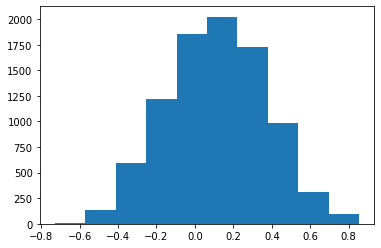

In [96]:
plt.hist([item for sublist in list(native_cos_sims.values()) for item in sublist])

In [97]:
def get_latent_rep(native_vectors, model_path):
    
    #import imp
    #imp.reload(module)
    
    vectors_torch = dl.TorchVectors(list(native_vectors.items()))
    val_loader = DataLoader(vectors_torch, batch_size=1, pin_memory=True, shuffle=False)

    # Retrieve the architecture of the model
    params = torch.load(model_path)
    latent_size, input_size = params['state_dict']['net.0.weight'].shape
    weights_encode = torch.nn.Parameter(params['state_dict']['net.0.weight'])
    
    # Initialize the encoding layer, apply weights
    to_latent_nn = nn.Linear(input_size, latent_size, bias=False)
    to_latent_nn.weight = weights_encode
    to_latent_nn.eval()
    to_latent_nn.cuda()
    
    output = dict()

    for idx, batch in enumerate(val_loader):
        
        key, vals = batch[0][0], batch[1]
        inputs = Variable(vals).cuda()
        with torch.no_grad():
            output[key] = to_latent_nn(inputs)
    to_latent_nn.cpu()

    latent_vectors = dict()

    for key, vals in output.items():
        latent_vectors[key] = vals.cpu().numpy()[0]
    
    return latent_vectors

#### Now map to the latent space for a model before checking the improvement in alignment

In [138]:
latent_vectors = get_latent_rep(lincs_vectors, "../trained_model_parameters/LeakyReLu/5.93e-06_counts150epoch_leakyReLu_960_1024_model_best.pth")

In [99]:
mean_vectors_latent = get_mean_vec_from_control(latent_vectors, pert_cell_vector_dict, cnt_condition = "DMSO", batch_cor = True)

In [100]:
latent_cos_sims = get_group_cos_sims(mean_vectors_latent, meta_data, grp_id = 'pert_iname', ind_id = 'cell_id', mean = False)

In [101]:
len(latent_cos_sims)

1418

(array([1455.,  932.,  667.,  553.,  536.,  537.,  594.,  690., 1049.,
        1946.]),
 array([-0.97505021, -0.7787416 , -0.58243299, -0.3861244 , -0.1898158 ,
         0.00649279,  0.20280139,  0.39910999,  0.59541857,  0.79172719,
         0.9880358 ]),
 <BarContainer object of 10 artists>)

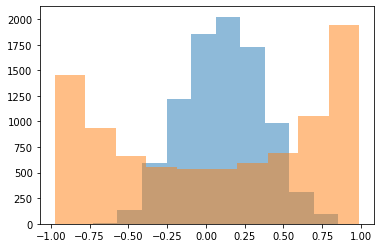

In [102]:
plt.hist([item for sublist in list(native_cos_sims.values()) for item in sublist], alpha = 0.5)
plt.hist([item for sublist in list(latent_cos_sims.values()) for item in sublist], alpha = 0.5)

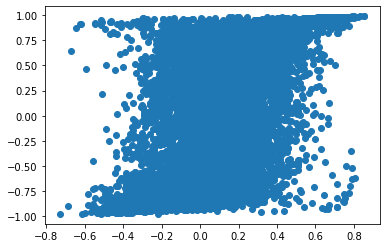

In [103]:
plt.scatter([item for sublist in list(native_cos_sims.values()) for item in sublist], [item for sublist in list(latent_cos_sims.values()) for item in sublist])

#### Do this in a loop to evaluate multiple architectures

In [ ]:
files = glob.glob('../trained_model_parameters/LeakyReLu/*.pth')

eval_df = pd.DataFrame(columns = ['Architecture', 'Loss (1e-6)', 'Abs. Alignment'])

for f in files[0:3]:
    
    latent_vectors = get_latent_rep(lincs_vectors, f)
    
    mean_vectors_latent = get_mean_vec_from_control(latent_vectors, pert_cell_vector_dict, cnt_condition = "DMSO", batch_cor = True)
    
    latent_cos_sims = get_group_cos_sims(mean_vectors_latent, meta_data, grp_id = 'pert_iname', ind_id = 'cell_id', mean = False)
    
    arch = '_'.join((files[1].split('\\')[1].split('_')[1:5]))
    loss = (files[1].split('\\')[1].split('_')[0]) * 1e6
    alignment = np.mean((np.abs([item for sublist in list(latent_cos_sims.values()) for item in sublist])))
    
    eval_df.loc[len(eval_df)] = [arch, loss, alignment]

In [ ]:
eval_df